In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DATA_FILE = "2dTSNE.json"
# DATA_FILE = "pca_tsne.json"
# DATA_FILE = "pca.json"

In [3]:

df = pd.read_json(DATA_FILE)

df["source"] = df["raga"].str.split("_").str[0]
# df["raga"] = df["raga"].str.split("_").str[1]

df.head()

,x,y,raga,seq,source
0,4.640824,-0.012556,H_abhogi kanada,srGmd's'sdmGrGmrsr.d.dsrmdssr.dsrGmGmrsGmrsGmr...,H
1,21.711260,4.014056,H_adana,srmpDNssDNpmpGmrssDNsDNpmpGmrsmmpsDNpmmpDNssDN...,H
2,16.856970,-9.628291,H_ahir bhairav,sRgmpdNssNdpmgmRRsgmRRsNdNRRsmgmRsssRgmmpgmgmp...,H
3,-13.788297,7.972342,H_alhaiya bilawal,sgp'spggrgpdNdpmgrgpdn'ssrgpdn's'sndpdNdpmgrs'...,H
4,-4.497239,16.141819,H_arabi,s.dsrmgrpmppp's'sdmpddmrgrs.dsrmgrpmppp's'sdmp...,H


In [4]:
# plot a smooth curve through the 5 random points

def smooth_curve(x, y):
	from scipy.interpolate import make_interp_spline

	# sort x,y to make sure the curve is smooth
	x_ind = np.argsort(x)
	x = x[x_ind]
	y = y[x_ind]

	spl = make_interp_spline(x, y, k=3)  # type: BSpline
	xnew = np.linspace(x.min(), x.max(), 300)

	y_smooth = spl(xnew)

	plt.plot(xnew, y_smooth)
	# plt.show()

In [5]:
def plot_points(sequences, title="Raga space"):
	# plot points in 2d
	plt.figure(figsize=(20, 20))
	if 'source' not in sequences.columns:
		sequences['source'] = 'all'
	if 'label' not in sequences.columns:
		sequences['label'] = sequences['raga']

	for source in sequences['source'].unique():
		data = sequences[sequences['source'] == source]
		plt.scatter(data['x'], data['y'], label=source, s=100, alpha=0.5, c=data['color'])

		# # plot a curve through the points
		# smooth_curve(data['x'].values, data['y'].values)
		
	# add labels
	for i, row in sequences.iterrows():
		plt.text(row['x'], row['y'], row['label'], fontsize=8)

	if 'ratio' in sequences.columns:
		text_height = 0.005
		# add ratios
		for i, row in sequences.iterrows():
			plt.text(row['x'], row['y'] + text_height, row['ratio'], fontsize=8)

	# from adjustText import adjust_text
	# texts = plt.gca().texts
	# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

	# draw a 3x3 grid
	xmin, xmax = plt.xlim()
	ymin, ymax = plt.ylim()

	x_ticks = np.linspace(xmin, xmax, 4)  # 3 equal parts = 4 tick positions
	y_ticks = np.linspace(ymin, ymax, 4)

	for x in x_ticks:
		plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)
	for y in y_ticks:
		plt.axhline(y=y, color='red', linestyle='--', linewidth=0.5)

	plt.legend()
	plt.title(title)
	plt.xlabel('x')
	plt.ylabel('y')
	plt.tight_layout()
	
	# save
	plt.savefig(title + ".pdf")

	plt.show()
	plt.close()


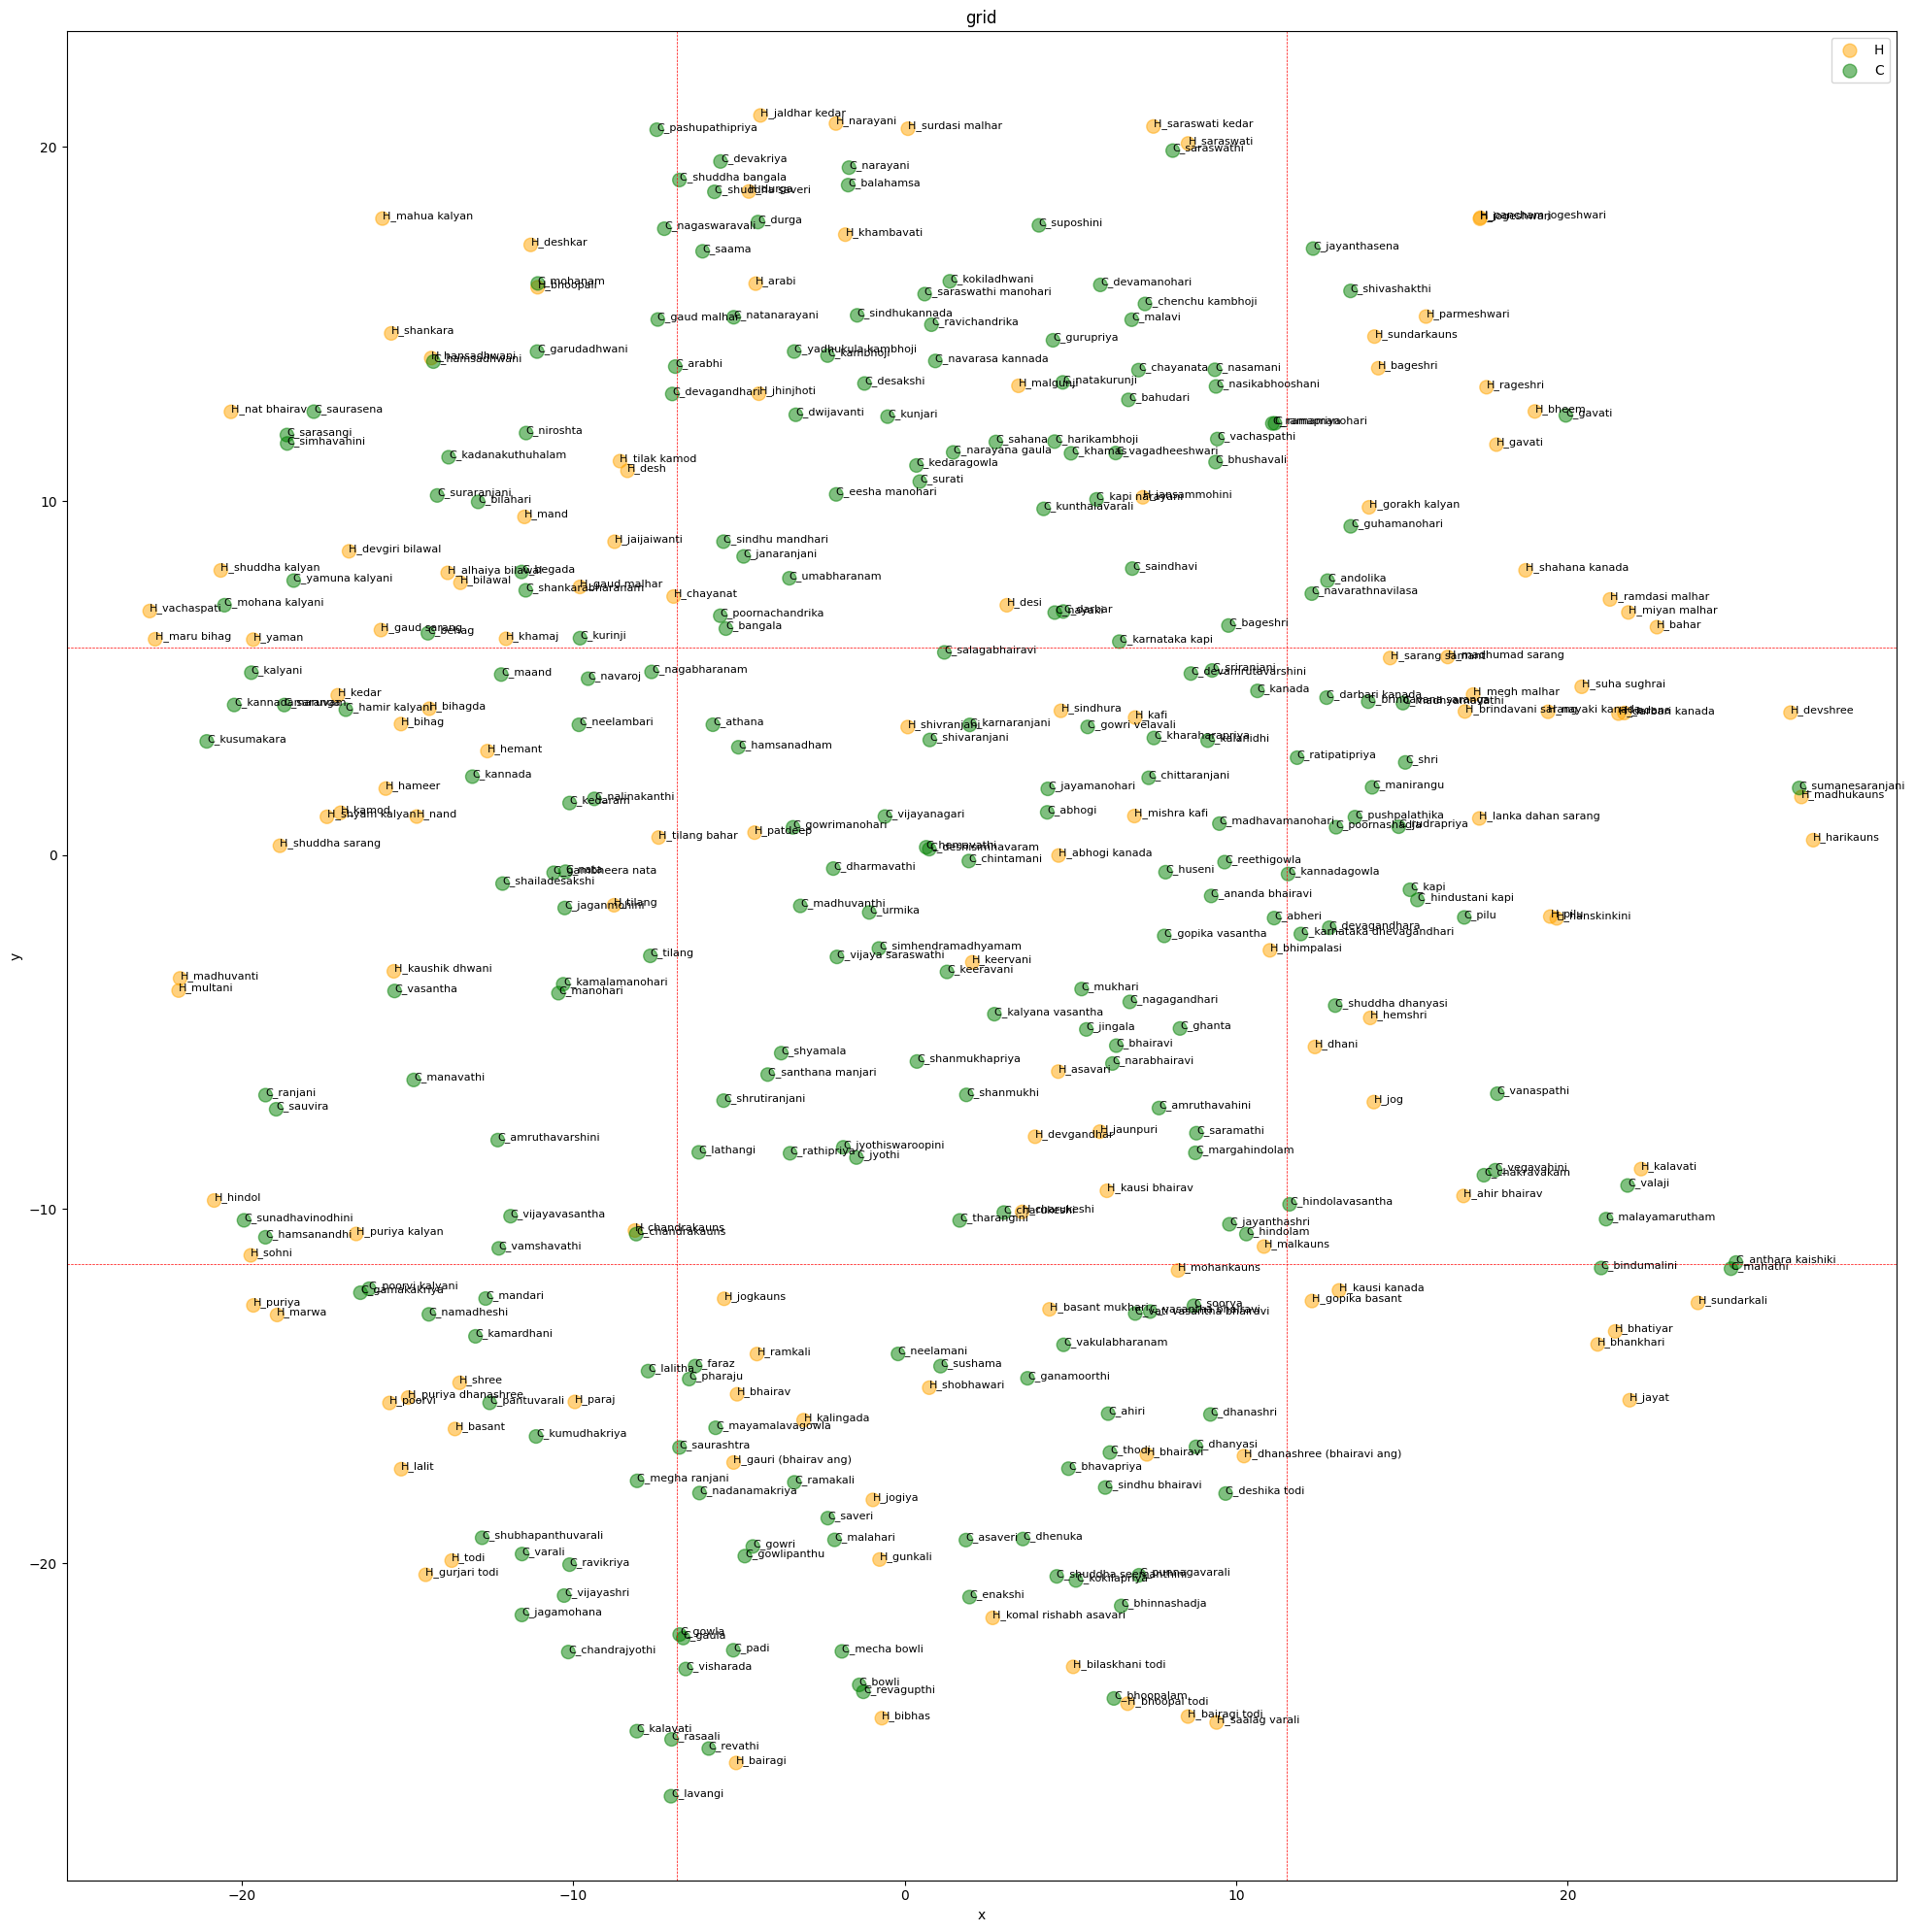

In [6]:

# # filter subset
subset_list = [
    'puriya', 'marwa', 'sohni', 'C_sunadhavinodhini', 'C_hamsanandhi',
    'hindol', 'deshkar', 'bhoopali', 'C_mohanam', 'C_durga',
    'C_shuddha saveri', 'C_revagupthi', 'C_bhoopalam', 'bibhas', 'C_kalyani',
    'yaman', 'yaman kalyan', 'C_mohana kalyani', 'shuddha kalyan',
    'C_amruthavarshini', 'C_thodi', 'C_sindhu bhairavi', 'bhairavi', 'bhairav',
    'C_mayamalavagowla', 'C_saveri', 'C_malahari', 'C_jaganmohini',
    'C_kamalamanohari', 'C_bowli', 'C_gowla', 'C_mecha bowli',
    'C_nadanamakriya', 'C_pharaju', 'C_lalitha'
]

kaustuv_paper = [
    'shuddha kalyan',
    'yaman kalyan',
    'yaman',
    'marwa',
    'puriya',
    'sohni',
    'alhaiya bilawal',
    'bihag',
    'shankara',
    'kafi',
    'bageshri',
    'bhimpalasi',
    'bhairav',
    'jaunpuri',
]

df2 = df.copy()
df3 = df2.copy()
# df3 = df2[df2['raga'].str.split('_').str[0].isin(kaustuv_paper)]

# color based on source
df3['color'] = df3['source'].map({"H": "orange", "C": "green"})

plot_points(df3, title="grid")

In [9]:
import json

def divide_and_save_cells(sequences, output_file="raga_cells.json"):
	if 'label' not in sequences.columns:
		sequences['label'] = sequences['raga']
	
	with open("db.json") as f:
		ragaDB = json.load(f)
	
	# keep only ragas which are in DB
	sequences = sequences[sequences['label'].isin(ragaDB.keys())].reset_index(drop=True)

	# Get x and y limits
	xmin, xmax = sequences['x'].min(), sequences['x'].max()
	ymin, ymax = sequences['y'].min(), sequences['y'].max()

	# Compute grid boundaries
	x_bounds = np.linspace(xmin, xmax, 4)  # 3 cells → 4 edges
	y_bounds = np.linspace(ymin, ymax, 4)

	# Create dictionary to hold 9 cells
	grid_cells = {f'cell_{i}{j}': [] for i in range(3) for j in range(3)}

	# Assign each point to a cell
	for i, row in sequences.iterrows():
		x, y = row['x'], row['y']
		label = row['label']

		# Find x and y cell index
		x_idx = np.searchsorted(x_bounds, x, side='right') - 1
		y_idx = np.searchsorted(y_bounds, y, side='right') - 1

		# Clip to ensure index is within [0, 2]
		x_idx = min(max(x_idx, 0), 2)
		y_idx = min(max(y_idx, 0), 2)

		cell_name = f'cell_{x_idx}{y_idx}'  # e.g. cell_01, cell_22
		grid_cells[cell_name].append(label)

	# Save to JSON
	with open(output_file, 'w') as f:
		json.dump(grid_cells, f, indent=2)

	print(f"Saved raga sets in 3x3 grid to '{output_file}'")



In [10]:
divide_and_save_cells(df, output_file="raga_grid_sets.json")

Saved raga sets in 3x3 grid to 'raga_grid_sets.json'
